# Predict Stabilizing Variants via Deep Mutational Scan

While ESM2 has similar performance to ESM-1v, the latter is still a great option for performing an _in silico_ deep mutational scan. ESM-1v is a collection of five models, trained on sequences from UniRef, each with different seeds. Ensembling these five models' scores can produce better results than a single ESM-1v model, for such broad topics like identifying stabilizing mutations.

Since these models were _only_ trained on functional molecules, they are capable of assessing whether a new molecule might also be functional, or whether it has a disastrous mutation.

Imagine only learning and speaking English your whole life - could you identify whether a new English word is English? Probably. What about whether a Korean word is Korean? Or whether a French word is French? You might not be able to identify a Korean word as *specifically* Korean since you were only exposed to English; but you can tell that some foreign words are at least *not-English*. The idea is similar with this zero-shot model, ESM-1v: how likely is a sequence *functional*, since the model was only exposed to functional sequences.

In [1]:
from helpers import api_caller

TOKEN = ''

We do this by masking each position and requesting the scores for each residue at that position. For a sequence of even a couple hundred residues, this is thousands of predictions from each of the 5 GPU-based models. [BioLM has APIs](https://api.biolm.ai/#54d3367a-b5d1-4f18-aa44-23ae3914a446) to get these results at scale much faster than it would take to spin up these models on multiple GPUs alone.

In [2]:
# Let's use the sequence from the paper
# https://www.biorxiv.org/content/10.1101/2021.07.09.450648v2.full.pdf
WILDTYPE = "ASKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"

print("Sequence length: {}".format(len(WILDTYPE)))

Sequence length: 238


We can copy working Python code for making a request to BioLM.ai's ESM-1v API:

In [3]:
async def esm1v_pred(seq, model_num=1):
    """Get un-masking predictions from any of the 5 ESM-1v models via REST API.
    
    From API docs: https://api.biolm.ai/#54d3367a-b5d1-4f18-aa44-23ae3914a446
    """
    slug = f'esm1v_t33_650M_UR90S_{model_num}'
    
    assert '<mask>' in seq
    assert 5 >= model_num >= 1

    data = {
      "instances": [
        {
          "data": {
            "text": seq
          }
        }
      ]
    }
    
    response = await api_caller(
        slug,
        'predict',
        data,
        TOKEN
    )
    
    return response

Now test our function on the first residue and first model.

In [4]:
pred = await esm1v_pred('<mask>' + WILDTYPE[1:], model_num=1)  # First ESM-1v model

In [5]:
from IPython.display import JSON


JSON(pred)

<IPython.core.display.JSON object>

We can see that `"M"`, or Methionine is the most likely starting AA. Methionine is a common starting AA amongst many organisms. 

Next, We can get predictions from the other ESM-1v models, then ensemble the likelihood scores for best results.

In [6]:
res = await esm1v_pred('<mask>' + WILDTYPE[1:], model_num=2)  # Second ESM-1v model

JSON(res)

<IPython.core.display.JSON object>

You can observe the probabilities for each token (amino acid residue) differing between the two models.

Loading the data into a DF is simple.

In [7]:
# FOR IN-BROWSER JUPYTER-LITE ONLY #
import micropip  # Install with `pip install matplotlib` if running notebook elsewhere
await micropip.install('pandas')

In [8]:
import pandas as pd

In [9]:
pd.DataFrame.from_dict(res['predictions'][0], orient='columns')

,score,token,token_str,sequence
0,0.945713,20,M,M S K G E E L F T G V V P I L V E L D G D V N ...
1,0.004731,4,L,L S K G E E L F T G V V P I L V E L D G D V N ...
2,0.004624,6,G,G S K G E E L F T G V V P I L V E L D G D V N ...
3,0.004320,8,S,S S K G E E L F T G V V P I L V E L D G D V N ...
4,0.003869,15,K,K S K G E E L F T G V V P I L V E L D G D V N ...
5,0.003802,7,V,V S K G E E L F T G V V P I L V E L D G D V N ...
6,0.003527,12,I,I S K G E E L F T G V V P I L V E L D G D V N ...
7,0.003489,5,A,A S K G E E L F T G V V P I L V E L D G D V N ...
8,0.003188,9,E,E S K G E E L F T G V V P I L V E L D G D V N ...
9,0.003166,11,T,T S K G E E L F T G V V P I L V E L D G D V N ...


Let's scan the whole sequence now, using all five models. This should be fairly fast sequentially. Let's simply loop through each model and position.

In [10]:
import asyncio
import copy
import random

# Limit concurrency to 3 requests at a time (*not* RPS)
sem = asyncio.Semaphore(3)


results = []

async def f(idx, seq, mdl):
    # Add small jitter
    jitter = random.randint(1, 100) / 100.0  
    await asyncio.sleep(jitter * 5)
    if idx % 20 == 0:
        print("Submitting position {}/{} with ESM-1v Model {}".format(idx, len(seq), mdl))
    # Mask that position
    seq_masked = list(copy.copy(seq))
    seq_masked[idx] = '<mask>'
    seq_masked = ''.join(seq_masked)

    # Request the probabilities of each AA at that mask
    async with sem:
        r = await esm1v_pred(seq_masked, model_num=mdl)
    r_df = pd.DataFrame.from_dict(r['predictions'][0], orient='columns')
    r_df['model_num'] = mdl
    r_df['mask_pos'] = idx
    
    return r_df


# We'll just query the first 4 models for now, that's enough
for mdl in range(1, 5):
    ops = [f(i, WILDTYPE, mdl) for i in range(len(WILDTYPE))]
    rets = await asyncio.gather(*ops)
    
    results.extend(rets)

Submitting position 120/238 with ESM-1v Model 1
Submitting position 60/238 with ESM-1v Model 1
Submitting position 180/238 with ESM-1v Model 1
Submitting position 160/238 with ESM-1v Model 1
Submitting position 100/238 with ESM-1v Model 1
Submitting position 220/238 with ESM-1v Model 1
Submitting position 80/238 with ESM-1v Model 1
Submitting position 40/238 with ESM-1v Model 1
Submitting position 140/238 with ESM-1v Model 1
Submitting position 20/238 with ESM-1v Model 1
Submitting position 0/238 with ESM-1v Model 1
Submitting position 200/238 with ESM-1v Model 1
Submitting position 120/238 with ESM-1v Model 2
Submitting position 100/238 with ESM-1v Model 2
Submitting position 0/238 with ESM-1v Model 2
Submitting position 80/238 with ESM-1v Model 2
Submitting position 220/238 with ESM-1v Model 2
Submitting position 40/238 with ESM-1v Model 2
Submitting position 200/238 with ESM-1v Model 2
Submitting position 60/238 with ESM-1v Model 2
Submitting position 160/238 with ESM-1v Model 2
Sub

In [11]:
results[0]  # Look at the first result DF we made

,score,token,token_str,sequence,model_num,mask_pos
0,0.909230,20,M,M S K G E E L F T G V V P I L V E L D G D V N ...,1,0
1,0.008935,4,L,L S K G E E L F T G V V P I L V E L D G D V N ...,1,0
2,0.007254,7,V,V S K G E E L F T G V V P I L V E L D G D V N ...,1,0
3,0.007158,6,G,G S K G E E L F T G V V P I L V E L D G D V N ...,1,0
4,0.006674,12,I,I S K G E E L F T G V V P I L V E L D G D V N ...,1,0
5,0.006055,8,S,S S K G E E L F T G V V P I L V E L D G D V N ...,1,0
6,0.005998,15,K,K S K G E E L F T G V V P I L V E L D G D V N ...,1,0
7,0.005336,11,T,T S K G E E L F T G V V P I L V E L D G D V N ...,1,0
8,0.005292,5,A,A S K G E E L F T G V V P I L V E L D G D V N ...,1,0
9,0.005089,18,F,F S K G E E L F T G V V P I L V E L D G D V N ...,1,0


Concatenate the resulting DFs together, horizontally.

In [12]:
results_df = pd.concat(results, axis=0)

results_df.shape

(19040, 6)

In [13]:
results_df.sample(5)  # Sample some of the results to get a preview

,score,token,token_str,sequence,model_num,mask_pos
17,0.012230,22,W,A S K G E E L F T G V V P I L V E L D G D V N ...,4,111
16,0.017972,18,F,A S K G E E L F T G V V P I L V E L D G D V N ...,4,40
17,0.013468,20,M,A S K G E E L F T G V V P I L V E L D G D V N ...,1,119
18,0.025137,21,H,A S K G E E L F T G V V P I L V E L D G D V N ...,3,204
13,0.027776,19,Y,A S K G E E L F T G V V P I L V E L D G D V N ...,4,221


Let's quickly fill in the WT character for each row so we can plot the results.

In [14]:
results_df['wt_token_str'] = results_df.mask_pos.apply(lambda x: WILDTYPE[x])

results_df.sample(3)

,score,token,token_str,sequence,model_num,mask_pos,wt_token_str
1,0.011308,4,L,L S K G E E L F T G V V P I L V E L D G D V N ...,4,0,A
0,0.085240,4,L,A S K G E E L F T G V V P I L V E L D G D V N ...,3,188,G
12,0.032508,13,D,A S K G E E L F T G V V P I L V E D D G D V N ...,3,17,L


Lastly, make a DF displaying a heatmap of the most probable stabilizing variants from the above _in silico_ deep mutational scan.

In [15]:
heatmap_df = []  # Each row represents the full sequence, with a single token_str at each position

for residue in results_df.token_str.drop_duplicates().to_list():
    tmp_row = []
    for pos in range(len(WILDTYPE)):
        token_position_score = results_df.query('token_str == @residue & mask_pos == @pos').score.iloc[0]
        tmp_row.append(token_position_score)
    heatmap_df.append(tmp_row)

In [16]:
heatmap_df = pd.DataFrame(heatmap_df)

heatmap_df.shape

(20, 238)

In [17]:
heatmap_df.head(1).iloc[0][0]

0.9092302322387695

In [18]:
# FOR IN-BROWSER JUPYTER-LITE ONLY #
await micropip.install('matplotlib')
await micropip.install('seaborn')

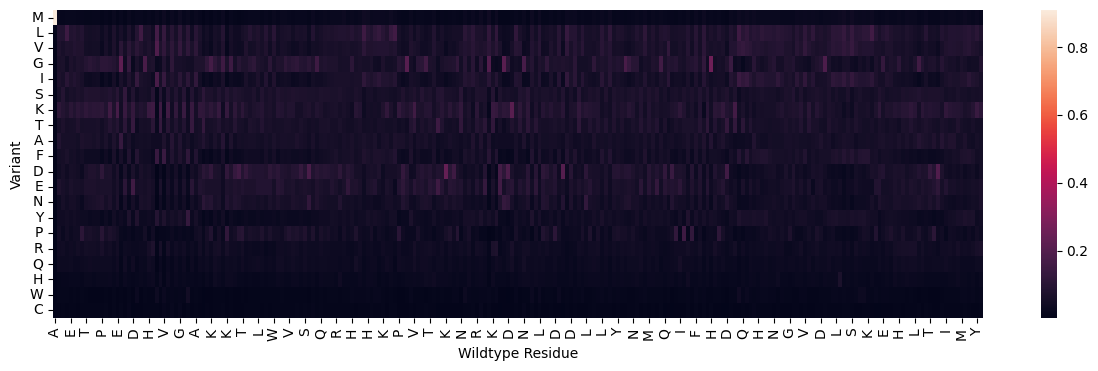

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=[15, 4])

ax = sns.heatmap(heatmap_df)
_ = ax.set_xticklabels(list(WILDTYPE)[::int(len(WILDTYPE)/50)])
_ = ax.set_yticklabels(results_df.token_str.drop_duplicates())
_ = ax.set(xlabel='Wildtype Residue', ylabel='Variant')

This is a quick depiciton of the results. What you want to look for in the DF is mutations where the score is greater than the score of the wild-type residue at the same location. These can be extracted with some quick slicing of `results_df`, which we'll leave up to you to explore. There appear to be several mutations with greater likelihood that the wild-type sequence.